In [1]:
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.cluster import SpectralBiclustering
from sklearn.metrics import consensus_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 16
rcParams['axes.linewidth'] = 2
rcParams['grid.linewidth'] = 2
rcParams['grid.color'] = 'gainsboro'
rcParams['font.weight'] = 'normal'
rcParams['axes.labelweight'] = 'bold'
rcParams['axes.labelsize'] = 21
rcParams['legend.edgecolor'] = 'none'

In [3]:
reg_dic = {'0':'Liver mets',
'1':'Omentum',
'2':'RUQ',
'3':'LUQ',
'4':'Epigastrium',
'5':'Mesentery',
'6':'Left paracolic gutter',
'7':'Right paracolic gutter',
'8':'Nothing',
'9':'POD',
'10':'Nothing',
'11':'Pleural',
'12':'Abd. wall',
'13':'LN abdomen infrarenal',
'14':'LN abdomen suprarenal',
'15':'LN supradiaphragmatic',
'16':'LN chest',
'17':'LN inguinal',
'18':'Lung nodule'}

In [4]:
df = pd.read_csv('../prediction/inputs/training_df.csv')
fclasses = pickle.load(open('../prediction/inputs/feature_classes.p','rb'))

In [5]:
X_cols = df.columns.values[1:-12]
vals = df[X_cols].astype(float)
data = vals.corr().abs()

In [6]:
fimaging = fclasses['volume']+fclasses['recist']+fclasses['semantic']+fclasses['global_radiomics']+fclasses['ratio_radiomics']
fother = fclasses['age_stage']+fclasses['ca125']+fclasses['ctdna']
data = data.loc[fimaging, fother]
orig_data = data.copy()
named_feats = list(data.index.values)

In [7]:
# Colors
categories = ['mediumseagreen']*len(fclasses['volume']) + \
 ['black']*len(fclasses['recist']) + \
 ['deepskyblue']*len(fclasses['semantic']) + \
 ['white']*len(fclasses['global_radiomics']) + \
 ['white']*len(fclasses['ratio_radiomics'])
categories = np.array(categories)

# Intensity radiomics
categories[['orig_avg' in x for x in named_feats]] = 'plum'
# Volume radiomics
categories[[(('orig_avg' in x) & ('vol' in x)) for x in named_feats]] = 'yellow'
categories[[(('orig_avg' in x) & ('HU' in x)) for x in named_feats]] = 'yellow'
# Shape radiomics
shape_feats = ['Compactness1','Compactness2','elongation','flatness','leastAxis','majorAxis','minorAxis','sphericity','spherDisprop',
              'surfArea','surfToVolRatio']
categories[[x.split('_')[0] in shape_feats for x in named_feats]] = 'indianred'
# Ratio radiomics
categories[['ratio_out_avg' in x for x in named_feats]] = 'moccasin'
categories[['ratio_rim_avg' in x for x in named_feats]] = 'aquamarine'
# Number of lesions
categories[['-num_' in x for x in named_feats]] = 'lightgrey'
categories[['n_lesions' in x for x in named_feats]] = 'lightgrey'

In [8]:
# Make the names prettier

# Tidy up 
named_feats = [sub.replace('_1', '') if not 'HU' in sub else sub for sub in named_feats]
named_feats = [sub.replace('_', ' ') for sub in named_feats]
named_feats = [sub.replace('vol', 'volume') if not 'volume' in sub else sub for sub in named_feats]
named_feats = [sub.replace('firstOrder', '(intensity)') for sub in named_feats]
named_feats = [sub.replace('2DAvg', '(texture)') for sub in named_feats]
named_feats = [sub.replace('orig avg', '') for sub in named_feats]
named_feats = [sub.replace('ratio out avg', 'buffer ratio') for sub in named_feats]
named_feats = [sub.replace('ratio rim avg', 'rim ratio') for sub in named_feats]
named_feats = [sub.replace('num', 'num.') for sub in named_feats]
named_feats = [sub.replace('n lesions', 'num. lesions') for sub in named_feats]
named_feats = [sub.replace('scan1', '') for sub in named_feats]
named_feats = [sub.replace('hypo', 'xxxxx') for sub in named_feats] # saving hypo so it's not affected by next line
named_feats = [sub.replace('pod', 'POD') for sub in named_feats]
named_feats = [sub.replace('xxxxx', 'hypo') for sub in named_feats]
named_feats = [sub.replace('recist', 'RECIST') for sub in named_feats]

# Radiomics names
named_feats = [sub.replace('totalEnergy', 'Total energy') for sub in named_feats]
named_feats = [sub.replace('robustMeanAbsDev', 'Robust mean abs. dev.') for sub in named_feats]
named_feats = [sub.replace('robustMedianAbsDev', 'Robust median abs. dev.') for sub in named_feats]
named_feats = [sub.replace('std', 'Std. dev.') for sub in named_feats]
named_feats = [sub.replace('autoCorr', 'Autocorr.') for sub in named_feats]
named_feats = [sub.replace('coeffVariation', 'Coeff. var.') for sub in named_feats]
named_feats = [sub.replace('filledVolume', 'Filled volume') for sub in named_feats]
named_feats = [sub.replace('interQuartileRange', 'Interquartile range') for sub in named_feats]
named_feats = [sub.replace('jointAvg', 'Joint avg.') for sub in named_feats]
named_feats = [sub.replace('jointEntropy', 'Joint entropy') for sub in named_feats]
named_feats = [sub.replace('jointMax', 'Joint max.') for sub in named_feats]
named_feats = [sub.replace('jointVar', 'Joint var.') for sub in named_feats]
named_feats = [sub.replace('leastAxis', 'Least axis') for sub in named_feats]
named_feats = [sub.replace('majorAxis', 'Major axis') for sub in named_feats]
named_feats = [sub.replace('minorAxis', 'Minor axis') for sub in named_feats]
named_feats = [sub.replace('meanAbsDev', 'Mean abs. dev.') for sub in named_feats]
named_feats = [sub.replace('medianAbsDev', 'Median abs. dev.') for sub in named_feats]
named_feats = [sub.replace('rms', 'RMS') for sub in named_feats]
named_feats = [sub.replace('spherDisprop', 'Spherical disprop.') for sub in named_feats]
named_feats = [sub.replace('sumAvg', 'Sum avg.') for sub in named_feats]
named_feats = [sub.replace('sumEntropy', 'Sum entropy') for sub in named_feats]
named_feats = [sub.replace('sumVar', 'Sum var.') for sub in named_feats]
named_feats = [sub.replace('surfArea', 'Surface area') for sub in named_feats]
named_feats = [sub.replace('surfToVolRatio', 'Surface to vol. ratio') for sub in named_feats]
named_feats = [sub.replace('invDiffMomNorm', 'Inverse diff. moment norm.') for sub in named_feats]
named_feats = [sub.replace('invDiffMom', 'Inverse diff. moment') for sub in named_feats]
named_feats = [sub.replace('invDiffNorm', 'Inverse diff. norm.') for sub in named_feats]
named_feats = [sub.replace('invDiff', 'Inverse diff.') for sub in named_feats]
named_feats = [sub.replace('invVar', 'Inverse var.') for sub in named_feats]
named_feats = [sub.replace('clustPromin', 'Cluster prominence') for sub in named_feats]
named_feats = [sub.replace('clustShade', 'Cluster shade') for sub in named_feats]
named_feats = [sub.replace('clustTendency', 'Cluster tendency') for sub in named_feats]
named_feats = [sub.replace('secondInfCorr', 'Information Corr. 2') for sub in named_feats]
named_feats = [sub.replace('firstInfCorr', 'Information Corr. 1') for sub in named_feats]
named_feats = [sub.replace('diffAvg', 'Diff. avg.') for sub in named_feats]
named_feats = [sub.replace('diffEntropy', 'Diff. entropy') for sub in named_feats]
named_feats = [sub.replace('diffVar', 'Diff. var.') for sub in named_feats]
named_feats = [sub.replace('haralickCorr', 'Haralick corr.') for sub in named_feats]

# Others
named_feats = [sub.replace('HU ', 'HU>') for sub in named_feats]

# Add site names
for site in list(reg_dic.keys())[::-1]:
    named_feats = [sub.replace('{}-'.format(site), '{} '.format(reg_dic[site])) for sub in named_feats]
named_feats = [sub.replace('-', ' ') for sub in named_feats]
named_feats = [sub.replace('minus', '-') for sub in named_feats]

# Comparison signs
named_feats = [sub.replace('v1', 'vol.>1') for sub in named_feats]
named_feats = [sub.replace('v0', 'vol.>0') for sub in named_feats]
named_feats = [sub.replace('v-', 'vol.>-') for sub in named_feats]

In [9]:
# Capitalize
named_feats = [sub.capitalize() if sub[0].islower() else sub for sub in named_feats]

# Create dictionary
feat_dic = {}
for ii in range(orig_data.shape[0]):
    feat_dic[orig_data.index.values[ii]] = named_feats[ii]

data.index = named_feats

In [10]:
# And the rows as well
named_ind = list(data.columns.values)

named_ind = [sub.replace('stage', 'Stage') for sub in named_ind]
named_ind = [sub.replace('Age_at_diagnosis', 'Age') for sub in named_ind]
named_ind = [sub.replace('CA125.closest_tx_start', 'CA-125') for sub in named_ind]
named_ind = [sub.replace('tMAD_noSZ_first', 'ctDNA tMAD') for sub in named_ind]
named_ind = [sub.replace('MAF', 'ctDNA TP53 MAF') for sub in named_ind]
named_ind = [sub.replace('Mutation.Status', 'ctDNA TP53 status') for sub in named_ind]

data.columns = named_ind

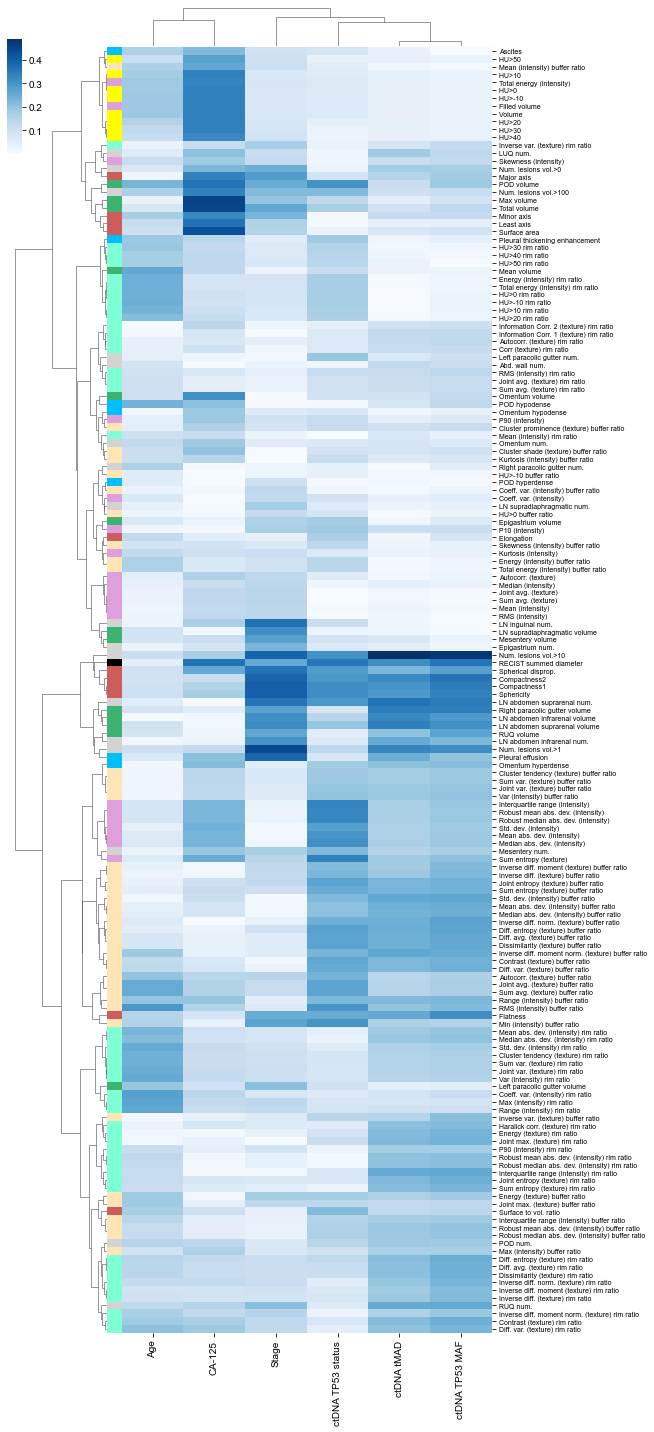

In [11]:
# Draw
g = sns.clustermap(data=data, method='ward', dendrogram_ratio=(.2, .03), 
                   cmap='Blues', yticklabels=1, figsize=(10,20), cbar_pos=(0.01, 0.89, 0.02, 0.08),
                  row_colors=categories)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 7)
plt.show()

In [12]:
dgram = g.dendrogram_row.dendrogram
ln = g.dendrogram_row.linkage

col_dgram = g.dendrogram_col.dendrogram
col_ln = g.dendrogram_col.linkage

Stage 0.9895238095238095 4
Age 0.9031491384432562 2
CA-125 0.9604166666666667 1
ctDNA tMAD 0.9761904761904762 4
ctDNA TP53 MAF 0.9661904761904763 4
ctDNA TP53 status 0.9423076923076923 5


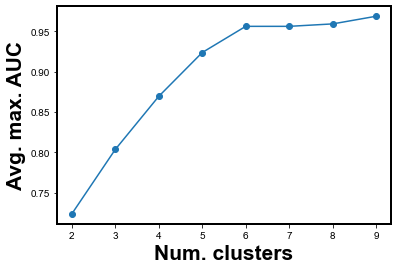

In [13]:
## Computation on the basis of correlation with biological variables

from sklearn import metrics
from sklearn.metrics import adjusted_mutual_info_score, roc_auc_score
from scipy.cluster.hierarchy import fcluster

nclusters = range(2,10)
mean_max_mis = []
for nclus in nclusters:
    fl = fcluster(ln,nclus,criterion='maxclust')
    max_mis = []
    for ivar in range(6):
        mis = []
        for iclus in range(1,nclus+1):
            corrs = (data.values[:,ivar]>0.15).astype(int)
            cluss = (fl==iclus).astype(int)
            corrs_pves = np.squeeze(np.argwhere(corrs==1))
            cluss_pves = np.squeeze(np.argwhere(cluss==1))
            #if nclus==5:
                #plt.plot(corrs_pves, np.ones_like(corrs_pves), 'o')
                #plt.plot(cluss_pves, np.zeros_like(cluss_pves), 'o')
                #plt.title('{}'.format(iclus))
                #plt.show()
            #mi = adjusted_mutual_info_score(cluss,corrs,average_method='arithmetic')
            mi = roc_auc_score(cluss, data.values[:,ivar])
            mis.append(mi)
        if nclus==6:
            print(data.columns.values[ivar], np.max(mis), np.argmax(mis)+1)
            #plt.plot(range(1,nclus+1), mis)
            #plt.show()
        max_mis.append(np.max(mis))
    mean_max_mis.append(np.mean(max_mis))
plt.plot(nclusters, mean_max_mis, '-o')
plt.xlabel('Num. clusters')
plt.ylabel('Avg. max. AUC')
plt.show()

In [14]:
fl = fcluster(ln,6,criterion='maxclust')

In [15]:
palette = sns.color_palette("gist_yarg", n_colors=6)
clus_colors = np.array(palette)[fl-1]
palette

[(0.8588235294117648, 0.8588235294117648, 0.8588235294117648),
 (0.7137254901960784, 0.7137254901960784, 0.7137254901960784),
 (0.5725490196078431, 0.5725490196078431, 0.5725490196078431),
 (0.4274509803921569, 0.4274509803921569, 0.4274509803921569),
 (0.28627450980392155, 0.28627450980392155, 0.28627450980392155),
 (0.14117647058823535, 0.14117647058823535, 0.14117647058823535)]

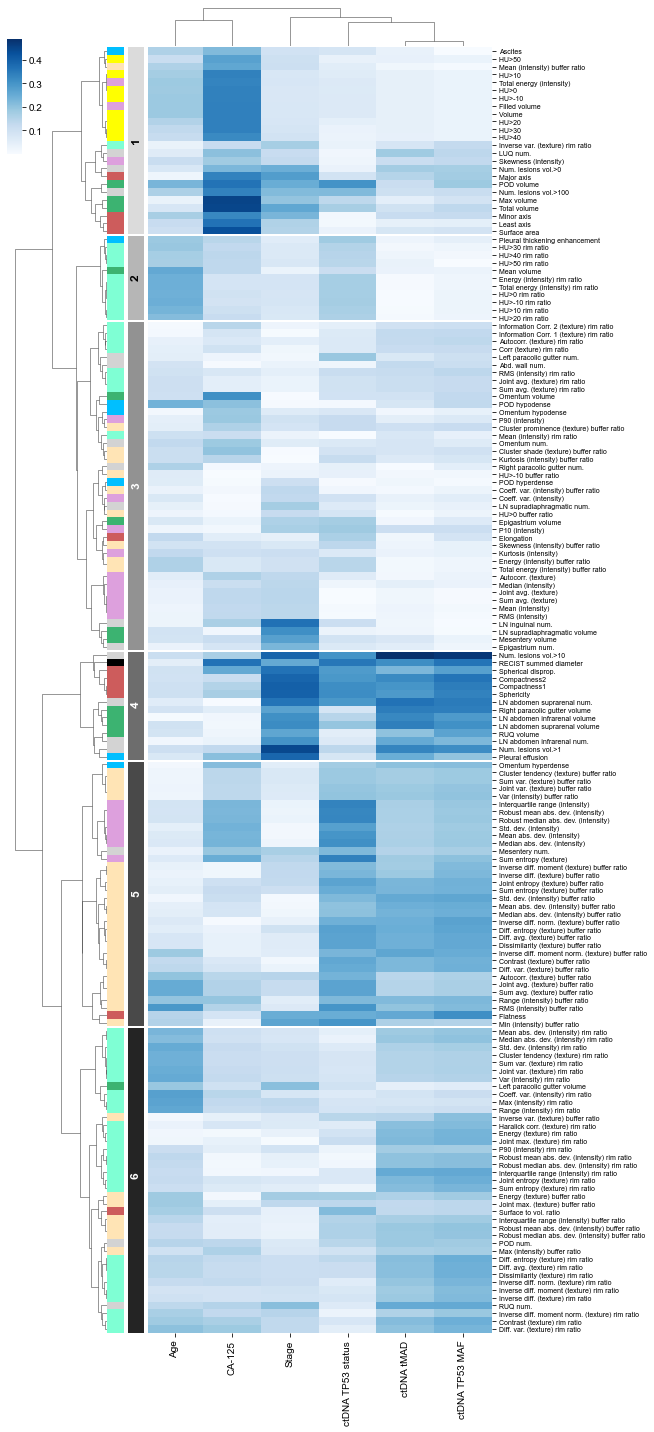

In [16]:
# Draw
g = sns.clustermap(data=data, method='ward', dendrogram_ratio=(.2, .03), 
                   cmap='Blues', yticklabels=1, figsize=(10,20), cbar_pos=(0.01, 0.89, 0.02, 0.08),
                  row_colors=[categories, clus_colors], colors_ratio=0.04)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 7)

# Vertical Lines
ax1 = g.ax_heatmap 
ax2 = g.ax_row_colors
ax1.axvline(0,0,10,color='white',linewidth=4)
ax2.axvline(1,0,10,color='white',linewidth=4)
ax2.axvline(2,0,10,color='white',linewidth=4)

# Horizontal Lines
ordered_cols = fl[g.dendrogram_row.reordered_ind]
init_col = ordered_cols[0]
prev_r = 0
for r,color in enumerate(ordered_cols):
    if color!=init_col:
        ax1.axhline(r,0,10,color='white',linewidth=2)
        ax2.axhline(r,0,2,color='white',linewidth=2)
        if color<4:
            ax2.text(1.25,prev_r+(r-prev_r)/2,str(init_col),color='black', rotation=90, size=12, fontweight='heavy')
        else:
            ax2.text(1.25,prev_r+(r-prev_r)/2,str(init_col),color='white', rotation=90, size=12, fontweight='heavy')
        init_col = color
        prev_r = r
ax2.text(1.2,prev_r+(r-prev_r)/2,str(init_col),color='white', rotation=90, size=12, fontweight='heavy')
plt.show()


# Export data
data.to_csv('data-export/figure_2a.txt')

In [17]:
from scipy.stats import spearmanr, pearsonr
from statsmodels.stats.multitest import multipletests

def round_to_1(x):
    return round(x, -int(np.floor(np.log10(abs(x)))))

--- 1
Max n_lesions_v0_1=318
  In total: 1


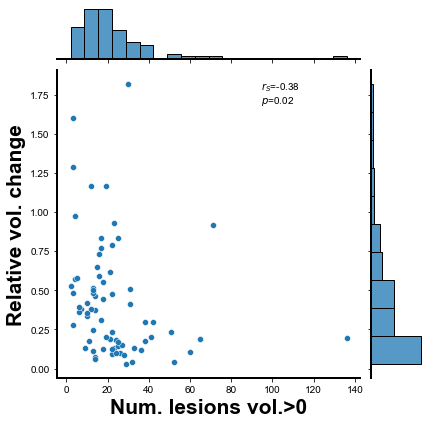

--- 2
Max energy_firstOrder_ratio_rim_avg=551
  In total: 10


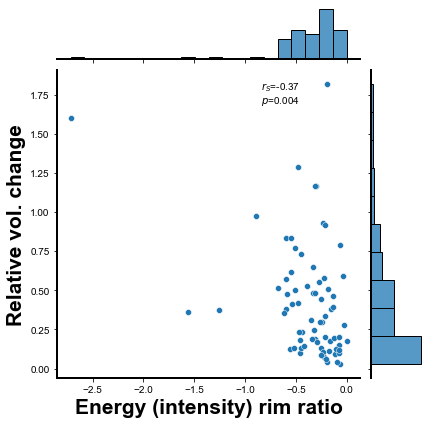

--- 3
Max HU_minus10_ratio_out_avg=551
  In total: 4


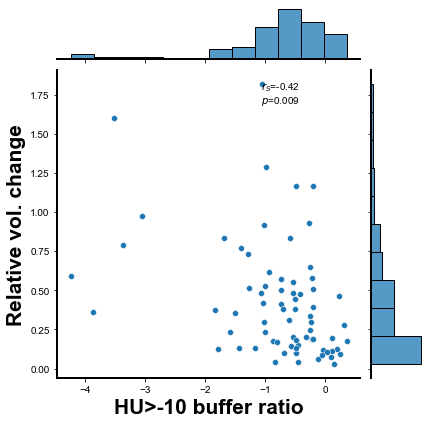

--- 4
Max n_lesions_v1_1=38
  In total: 0


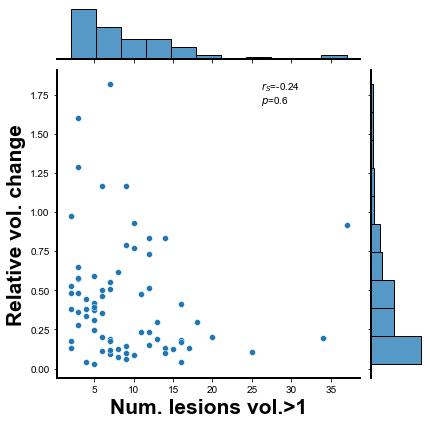

--- 5
Max sumEntropy_2DAvg_orig_avg=38
  In total: 21


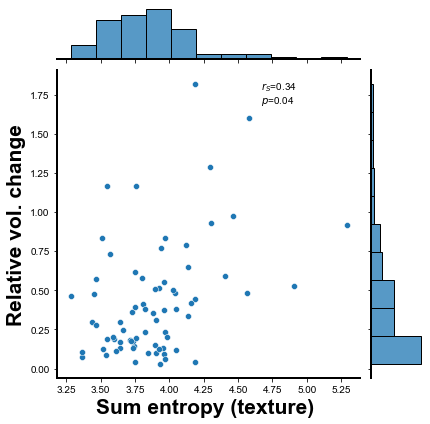

--- 6
Max invVar_2DAvg_ratio_out_avg=38
  In total: 0


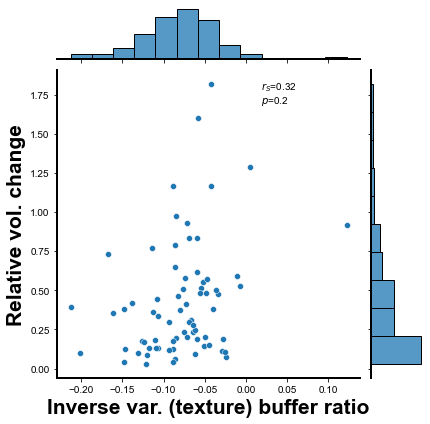

In [18]:
# Clear output file
open('data-export/figure_2b_scatter.txt', 'w').close()

# And generate plots
summary_feats = []
for c in np.unique(fl):
    print('---',c)
    feats = orig_data.index.values[fl==c]
    nice_feats = data.index.values[fl==c]
    
    all_abs_rs = []
    all_ps = []
    for f in feats:
        r,p = spearmanr(df[f].values, df['relative_change'].values)
        all_abs_rs.append(np.abs(r))
        all_ps.append(p)
        
    sel_ind = np.argmax(all_abs_rs)
    sel_feat = feats[sel_ind]
    
    summary_feats.append(sel_feat)
    
    # Plot
    #plt.hist(df[sel_feat].values)
    #plt.xlabel(nice_feats[sel_ind])
    #plt.show()
    
    max_id = np.argmax(df[sel_feat].values)
    max_index = df.loc[df.index.values[max_id], 'id']
    print('Max {}={}'.format(sel_feat,max_index))
    
    g = sns.jointplot(
        data=df,
        x=sel_feat, y="relative_change", kind='scatter')
    
    r,p = spearmanr(df[sel_feat], df['relative_change'])
    corr_ps = multipletests(all_ps,method='fdr_bh')
    corr_p = corr_ps[1][sel_ind]
    print('  In total: {}'.format(np.sum(corr_ps[1]<=0.05)))
    
    g.set_axis_labels(feat_dic[sel_feat], 'Relative vol. change')
    g.fig.text(0.6, 0.75, '$r_S$={:.2f}\n$p$={}'.format(r,round_to_1(corr_p)))
    plt.show()
    
    df[[sel_feat,'relative_change']].to_csv('data-export/figure_2b_scatter.txt', mode='a')

In [19]:
df_test = df.copy()
df_test['relative_change_stratified'] = df_test['relative_change']>np.median(df_test['relative_change'])

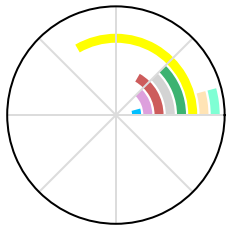

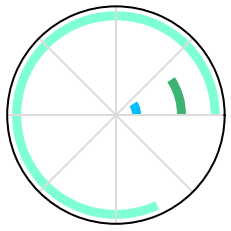

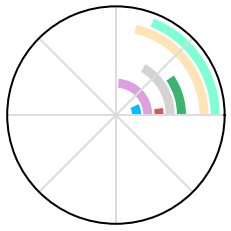

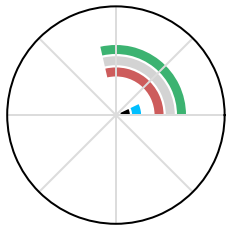

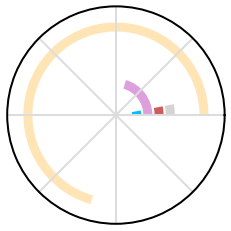

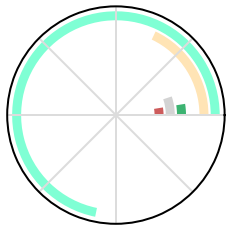

In [20]:
# First figure out the best ordering
cat_counts = {}
for c in np.unique(fl):
    feats = orig_data.index.values[fl==c]
    nice_feats = data.index.values[fl==c]
    cats = categories[fl==c]
    for d in np.unique(categories):
        if d not in cat_counts:
            cat_counts[d] = []
        cat_counts[d].append( np.count_nonzero(cats==d)/len(nice_feats) )

cat_max = [np.max(cat_counts[v]) for v in list(cat_counts.keys())]
cat_sort = np.array(list(cat_counts.keys()))[np.argsort(cat_max)]

# And then plot
outfile = open('data-export/figure_2b_barplot.txt','w')

for ic,c in enumerate(np.unique(fl)):
    feats = orig_data.index.values[fl==c]
    nice_feats = data.index.values[fl==c]
    cats = categories[fl==c]
    
    cat_counts = []
    for d in cat_sort:
        cat_counts.append( np.count_nonzero(cats==d) )

    # Circular plots
    ax = plt.subplot(projection='polar')
    xvec = list(range(len(cat_counts)))
    yvec = cat_counts/np.sum(cat_counts)*2*np.pi
    ax.barh(xvec, yvec,
        color=cat_sort)
    ax.yaxis.grid(False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])    
    plt.show()
    
    outfile.write('{}\n'.format(ic+1))
    outfile.write('{}\n'.format(','.join([str(xx) for xx in xvec])))
    outfile.write('{}\n'.format(','.join([str(yy) for yy in yvec])))
outfile.close()